In [79]:
%run tools.ipynb

In [80]:
# compare CO2 results from 2 cases, they are both 2018-Jan
# one is with prior only
# the other is simulated with posterior

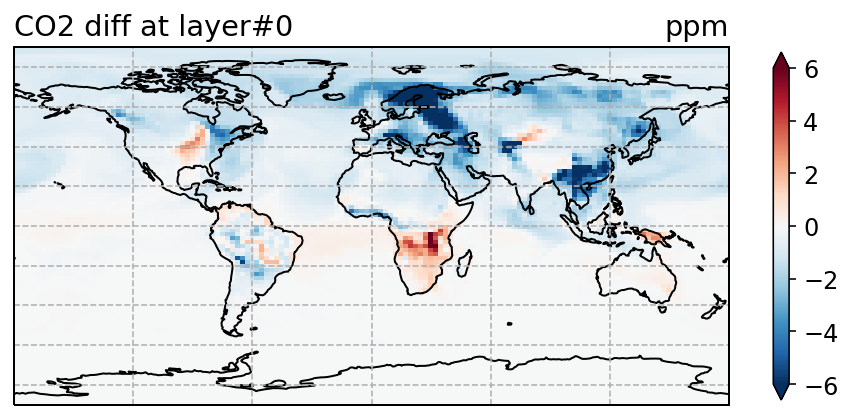

In [81]:
# Check CO2 at the surface
def get_surface(casename, ilayer):
    top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-test-2018/nd51/'
    fname = '/ts_satellite.20180131.nc'
    ds_tmp = xr.open_dataset(top_dir + casename + fname)
    dr_CO2 = ds_tmp['SpeciesConc_CO2'][0,ilayer,:,:]/1000
    return dr_CO2

layer = 0
dr_jan = get_surface('Jan', layer)
dr_feb = get_surface('Feb', layer)
diff = dr_feb - dr_jan

fig = plt.figure(figsize=[8, 8])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
diff.plot(ax=ax, vmax = 6, add_labels = False, cbar_kwargs={'shrink': 0.4})
ax.set_title('CO2 difference at layer#' + str(layer),loc = 'left');
ax.set_title('ppm', loc = 'right')
ax.coastlines()
ax.gridlines(linestyle = '--')


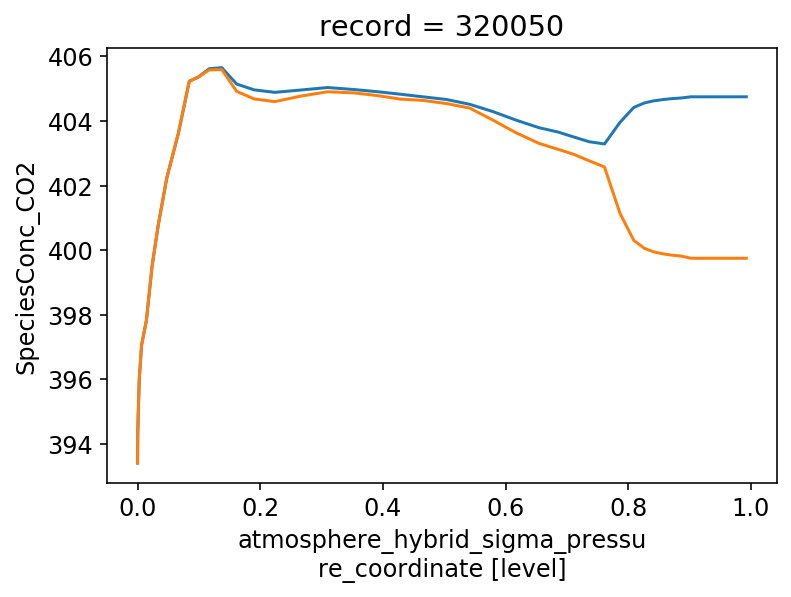

In [82]:
# check CO2 profile after flattening output to 2d
def get_2d(casename):
    top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-test-2018/nd51/'
    fname = '/2d_ts_satellite.201801.nc'
    ds_tmp = xr.open_dataset(top_dir + casename + fname)
    dr_CO2 = ds_tmp['SpeciesConc_CO2'][:,:]/1000
    return dr_CO2
tmp1 = get_2d('Jan')
tmp2 = get_2d('Feb')
diff = tmp2 - tmp1
np.argmax(diff[:,19])
tmp2[320050,:].plot() # picked a location with significant change in surface flux
tmp1[320050,:].plot()
# CO2 profiles before interpolation

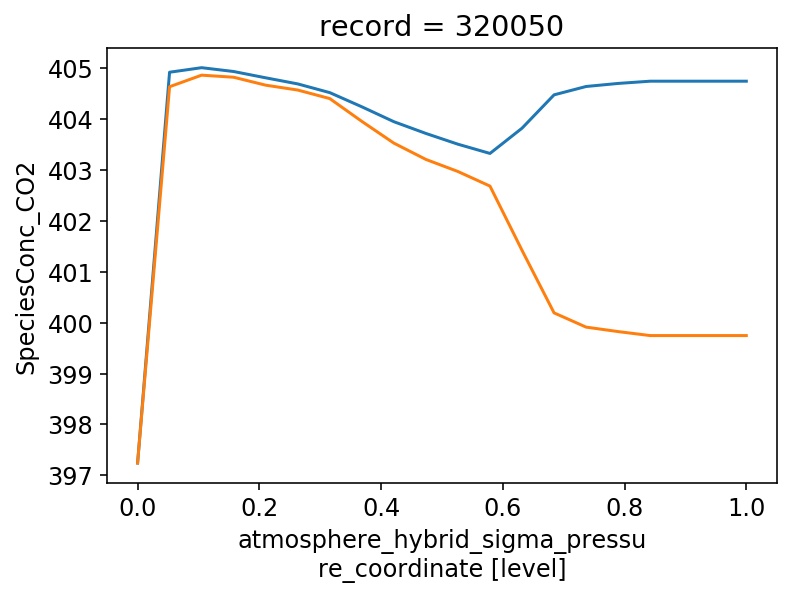

In [83]:
# check CO2 profile after interpolation
def get_intp(casename):
    top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-test-2018/nd51/'
    fname = '/interpolated_2d_ts_satellite.201801.nc'
    ds_tmp = xr.open_dataset(top_dir + casename + fname)
    dr_CO2 = ds_tmp['SpeciesConc_CO2'][:,:]/1000
    return dr_CO2
tmp1 = get_intp('Jan')
tmp2 = get_intp('Feb')
diff = tmp2 - tmp1
np.argmax(diff[:,19])
tmp2[320050,:].plot()
tmp1[320050,:].plot()
# interpolated CO2 profiles

In [84]:
# Some inputs for next calculation
top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-test-2018/nd51/' 
mod_dir1 = top_dir + 'Jan/'
mod_dir2 = top_dir + 'Feb/'

sat_dir = '/geos/u73/msadiq/satellite/oco-2/'
year = 2018
month = 1
mode = 'N'
str1_mod = 'interpolated_2d_ts_satellite.'
str1_sat = '2d_OCO2_extract_'


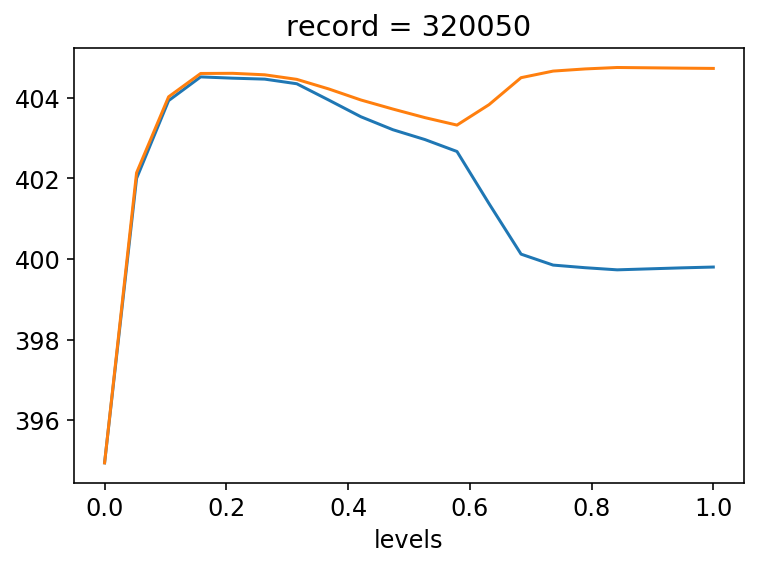

In [85]:
# Check XCO2 calculation
sat_file = str1_sat + str(year) + month_string(month) + '.nc'
ds_sat = xr.open_dataset(sat_dir + sat_file)
    
avg_kern = ds_sat['xco2_averaging_kernel']
co2_pr   = ds_sat['co2_profile_apriori']
pres_wgt = ds_sat['pressure_weight']
op_mode  = ds_sat['operation_mode'] # 0=Nadir, 1=Glint
mode_mask= (op_mode-1)*-1    # mask to mask out glint, 1=Nadir, 0=Glint
xco2 = ds_sat['xco2']

mod_file = str1_mod + str(year) + month_string(month) + '.nc'
ds_mod1 = xr.open_dataset(mod_dir1 + mod_file)
ds_mod2 = xr.open_dataset(mod_dir2 + mod_file)

# model simulated CO2 concentration
co2_model1 = ds_mod1['SpeciesConc_CO2']*1e-3 # unit: ppbv to ppmv 
co2_model2 = ds_mod2['SpeciesConc_CO2']*1e-3 # unit: ppbv to ppmv 

co2_profile1 = co2_pr + avg_kern * (co2_model1-co2_pr)
co2_profile2 = co2_pr + avg_kern * (co2_model2-co2_pr)

co2_profile1[320050,:].plot()
co2_profile2[320050,:].plot()

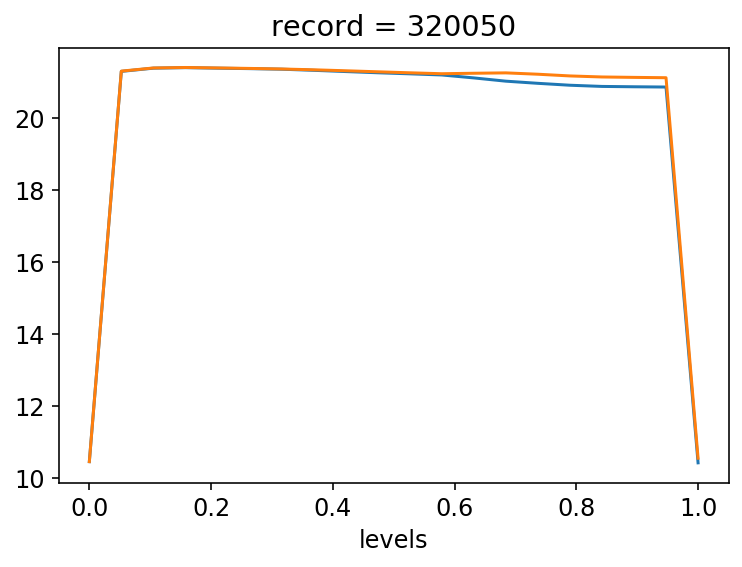

In [86]:
co2_profile1 = co2_profile1 * pres_wgt
co2_profile2 = co2_profile2 * pres_wgt
co2_profile1[320050,:].plot()
co2_profile2[320050,:].plot()

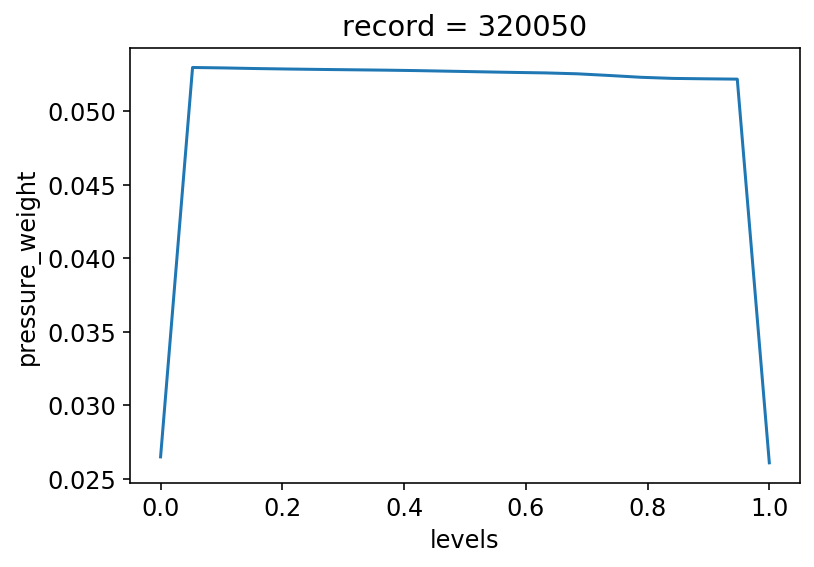

In [87]:
pres_wgt[320050,:].plot()


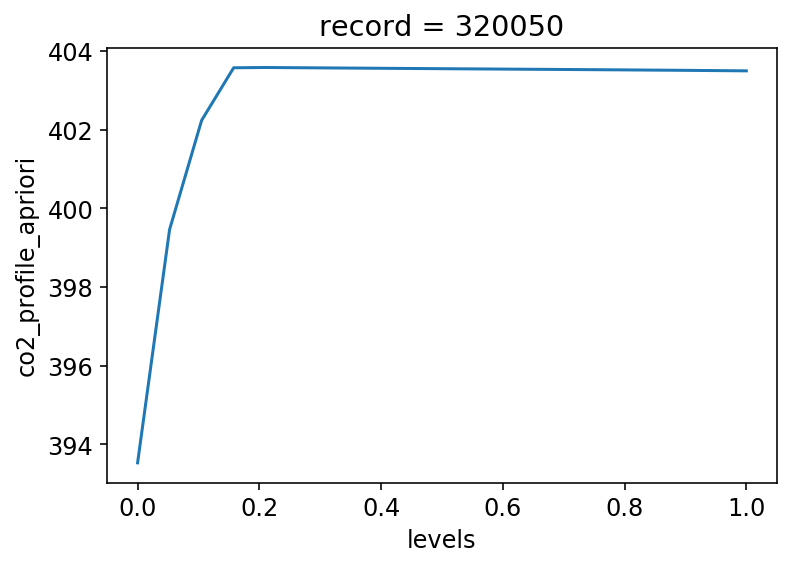

In [88]:
co2_pr[320050,:].plot()

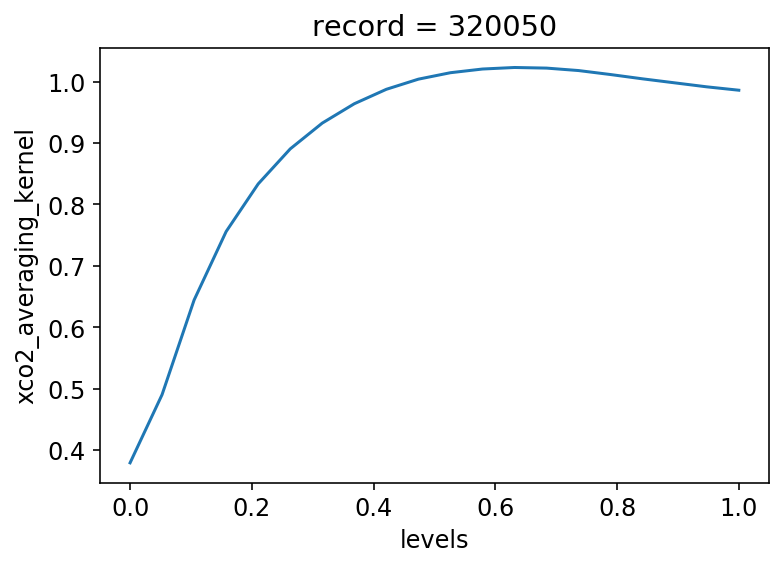

In [89]:
avg_kern[320050,:].plot()

In [90]:
# function to compare XCO2 from two different model runs
def compare_XCO2(mod_dir1, mod_dir2, sat_dir, year, month, str1_mod, str1_sat, mode):
    mod_file = str1_mod + str(year) + month_string(month) + '.nc'
    sat_file = str1_sat + str(year) + month_string(month) + '.nc'
    ds_mod1 = xr.open_dataset(mod_dir1 + mod_file)
    ds_mod2 = xr.open_dataset(mod_dir2 + mod_file)

    ds_sat = xr.open_dataset(sat_dir + sat_file)
    
    # mask data: predefined region, land vs. ocean, latitudinal bands
    mask_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/'
    mask_name     = 'flatten_mask.nc'
    ds_mask = xr.open_dataset(mask_directory + mask_name)

    avg_kern = ds_sat['xco2_averaging_kernel']
    co2_pr   = ds_sat['co2_profile_apriori']
    pres_wgt = ds_sat['pressure_weight']
    op_mode  = ds_sat['operation_mode'] # 0=Nadir, 1=Glint
    mode_mask= (op_mode-1)*-1    # mask to mask out glint, 1=Nadir, 0=Glint

    # model simulated CO2 concentration
    co2_model1 = ds_mod1['SpeciesConc_CO2']*1e-3 # unit: ppbv to ppmv 
    co2_profile1 = pres_wgt * (co2_pr + avg_kern * (co2_model1 - co2_pr))

    #co2_profile1 = pres_wgt * (1 - avg_kern) * co2_pr + pres_wgt * avg_kern * co2_model1
    # sum up to get column CO2
    xco2_model1 = co2_profile1.sum(dim = 'levels') # sum along vertical axis, unit: ppbv to ppm
    xco2_model_mode1 = xco2_model1 * mode_mask # extract desired mode of observation: Nadir
    
    co2_model2 = ds_mod2['SpeciesConc_CO2']*1e-3 # unit: ppbv to ppmv 
    co2_profile2 = pres_wgt * (co2_pr + avg_kern * (co2_model2 - co2_pr))
    #co2_profile2 = pres_wgt * (1 - avg_kern) * co2_pr + pres_wgt * avg_kern * co2_model2
    # sum up to get column CO2
    xco2_model2 = co2_profile2.sum(dim = 'levels') # sum along vertical axis, unit: ppbv to ppm
    xco2_model_mode2 = xco2_model2 * mode_mask # extract desired mode of observation: Nadir
    
    
    xco2_oco2_mode = ds_sat['xco2'] * mode_mask

    obs_series = xco2_oco2_mode.values
    model_series1 = xco2_model_mode1.values
    model_series2 = xco2_model_mode2.values
    obs_series[obs_series==0] = 'nan'
    model_series1[model_series1==0] = 'nan'
    model_series2[model_series2==0] = 'nan'
    
    R1 = ma.corrcoef(ma.masked_invalid(obs_series), ma.masked_invalid(model_series1))
    R2 = ma.corrcoef(ma.masked_invalid(obs_series), ma.masked_invalid(model_series2))
    x = obs_series[~np.isnan(obs_series)]
    y1 = model_series1[~np.isnan(model_series1)]
    y2 = model_series2[~np.isnan(model_series2)]
    rmse1 = np.sqrt(((y1 - x) ** 2).mean())
    rmse2 = np.sqrt(((y2 - x) ** 2).mean())
    format_R1 = float("{0:.2f}".format(R1[0,1]))
    format_rmse1 = float("{0:.2f}".format(rmse1))
    print('R1 is:', format_R1, ' RMSE1 is: ', format_rmse1)

    format_R2 = float("{0:.2f}".format(R2[0,1]))
    format_rmse2 = float("{0:.2f}".format(rmse2))
    print('R2 is:', format_R2, ' RMSE2 is: ', format_rmse2)

    xco2_model_land1 = xco2_model_mode1 * ds_mask['land'][0:len(xco2_model1)]
    xco2_model_land1[xco2_model_land1==0] = 'nan'
    xco2_model_land2 = xco2_model_mode2 * ds_mask['land'][0:len(xco2_model2)]
    xco2_model_land2[xco2_model_land2==0] = 'nan'
    xco2_oco2_land = xco2_oco2_mode * ds_mask['land'][0:len(xco2_model1)]
    xco2_oco2_land[xco2_oco2_land==0] = 'nan'

    fig = plt.figure(figsize=[5,5])
    name_month = short_name_of_month(month)
    #for region in ['high_lat', 'mid_lat', 'low_lat']:
    #    xco2_model_mask = xco2_model_land * ds_mask[region][0:len(xco2_model_land)]
    #    xco2_model_mask[xco2_model_mask==0] = 'nan'
    #    xco2_oco2_mask = xco2_oco2_land * ds_mask[region][0:len(xco2_model_land)]
    #    xco2_oco2_mask[xco2_oco2_mask==0] = 'nan'

    plt.scatter(xco2_oco2_land, xco2_model_land1, s=0.7, label = 'Jan')
    plt.scatter(xco2_oco2_land, xco2_model_land2, s=0.7, label = 'Feb')
    plt.plot([300,450],[300,450], c='r')
    plt.ylim(top   = 413,bottom = 400)
    plt.xlim(right = 413,left   = 400)
    plt.title(name_month + ' XCO2 (ppm)')
    plt.ylabel('GEOS-Chem')
    plt.xlabel('OCO2')
    plt.legend(markerscale = 4)

    plt.text(x=410, y=404, s='R1: ' + str(format_R1), size = 12)
    plt.text(x=410, y=403, s='RMSE1: ' + str(format_rmse1), size = 12)
    
    plt.text(x=410, y=402, s='R2: ' + str(format_R2), size = 12)
    plt.text(x=410, y=401, s='RMSE2: ' + str(format_rmse2), size = 12)
    #fig.savefig(mod_dir + '/mod_vs_obs_XCO2_latitudinal_'+ mode + '_' + name_month + '.png', dpi=300)
    
    # Creat target dataarray and dataset
    lat_res = 2    # horizontal resolution of lat and lon you would want
    lon_res = 2.5
    lat = np.linspace(-90, 90, int(180/lat_res + 1)) # grid
    lon = np.linspace(-180, 177.5, int(360/lon_res))
    days = len(diff)/(len(lat)*len(lon))

    var_3d = xr.DataArray(data = np.nan, 
                          dims = ('days', 'lat', 'lon'), 
                          coords = {'days': range(int(days)),
                                    'lat': lat,
                                    'lon': lon},
                          name = 'diff')
    var_3d = var_3d.astype(dtype='float32')

    diff2 = xco2_model_land2 - xco2_model_land1 # diff to map onto global map
    var_3d.values = diff2.values.reshape((int(days),len(lat),len(lon)))
    
    var_2d = var_3d.mean(dim='days')
    # plot after mapping
    fig = plt.figure(figsize=[8, 8])
    proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj)
    # 
    var_2d.plot(ax=ax, vmax = 3, add_labels = False, cbar_kwargs={'shrink': 0.4})
    ax.set_title(name_month + ' XCO2: a posterior - OCO2', loc = 'left');
    ax.set_title('ppm', loc = 'right')
    ax.coastlines()
    ax.gridlines(linestyle = '--')
    

R1 is: 0.72  RMSE1 is:  1.34
R2 is: 0.73  RMSE2 is:  1.28


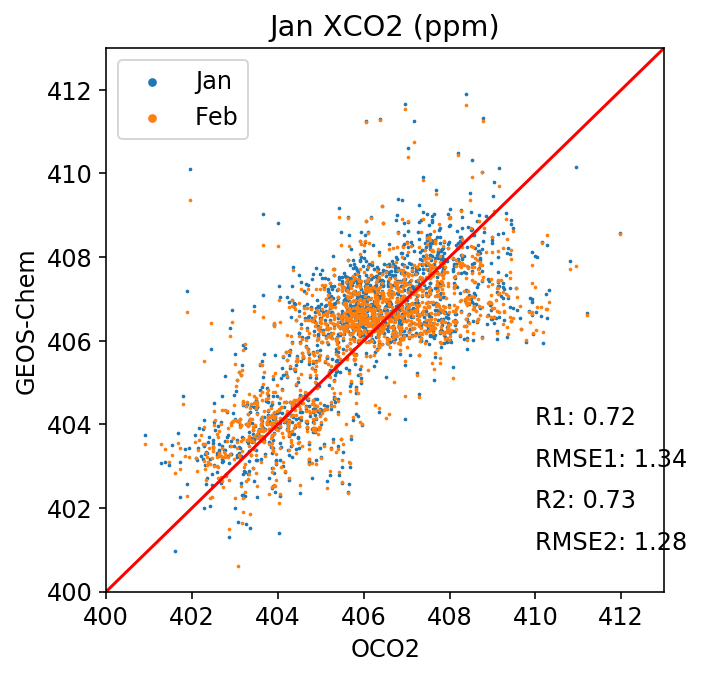

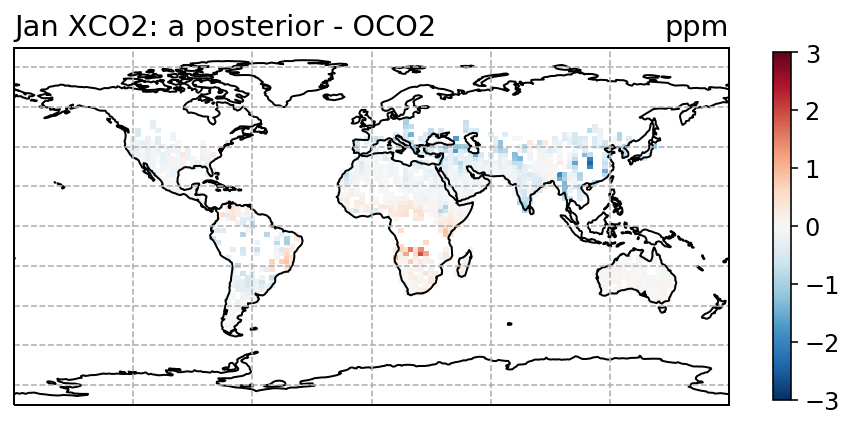

In [91]:
compare_XCO2(mod_dir1, mod_dir2, sat_dir, year, month, str1_mod, str1_sat, mode)